## INFO https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3951655/

In [1]:
%%capture
!pip install datasets
!pip install sentencepiece
!pip install dataprep
!pip install simpletransformers
!pip install colorama

In [2]:
from simpletransformers.ner import NERModel, NERArgs

In [3]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import keras.backend as K


from dataprep.eda import plot, plot_correlation, create_report, plot_missing
from pprint import pprint

from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import spacy
from tqdm import tqdm 


NumExpr defaulting to 2 threads.


In [4]:
from colorama import Fore

def print_color(prediction):
  for sentence in prediction[0]:
    for key, val in sentence.items():
      if val == 'O':
        print(Fore.GREEN + key + ' - O')
      if val == 'B_Disease':
        print(Fore.BLUE + key + ' - B_Disease')
      if val == 'I_Disease':
        print(Fore.RED + key + ' - I_Disease')

#### The NCBI Disease corpus consists of 793 PubMed abstracts, which are separated into training (593), development (100) and test (100) subsets. The NCBI Disease corpus is annotated with disease mentions, using concept identifiers from either MeSH or OMIM.

In [5]:
from datasets import load_dataset
dataset = load_dataset("ncbi_disease")

⏳ Generating examples from = /root/.cache/huggingface/datasets/downloads/d1cf8cec69c23a6b34c32a4c3cd81c8273880a9e1c3447d47ca90be96dca8d8f


⏳ Generating examples from = /root/.cache/huggingface/datasets/downloads/d35a3a5732b07182c92cc3a7f1b3ab156983d83a885a1384fb5094fc8eca5ae7


⏳ Generating examples from = /root/.cache/huggingface/datasets/downloads/39cd2eb58d611982f617aac24752091ba0f3b84d863fd3976c922a7a7b0b26e7


Dataset ncbi_disease downloaded and prepared to /root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/88b09d40ea6f23141af303fa5f80b07d7de87612b2e41f494f537c4eff97372c. Subsequent calls will reuse this data.


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [7]:
df_train = pd.DataFrame(dataset['train'])
df_valid = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

In [8]:
eda_df = pd.concat([df_train,df_valid,df_test], ignore_index=True)
eda_df.shape

(7298, 3)

### ner_tags: Array of tags, where 0 indicates no disease mentioned, 1 signals the first token of a disease and 2 the subsequent disease tokens. 

In [9]:
df_train

,id,ner_tags,tokens
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[Identification, of, APC2, ,, a, homologue, of..."
1,1,"[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[The, adenomatous, polyposis, coli, (, APC, ),..."
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[Complex, formation, induces, the, rapid, degr..."
3,3,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, colon, carcinoma, cells, ,, loss, of, APC..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Here, ,, we, report, the, identification, and..."
...,...,...,...
5428,5428,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Here, ,, we, show, that, retroviral, transfer..."
5429,5429,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, ...","[Mutant, BRCA1, has, no, effect, on, growth, o..."
5430,5430,"[0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Development, of, MCF, -, 7, tumours, in, nude..."
5431,5431,"[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, ...","[Most, importantly, ,, among, mice, with, esta..."


In [22]:
pprint(eda_df['ner_tags'].iloc[0])
pprint(eda_df['tokens'].iloc[0])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]
['Identification',
 'of',
 'APC2',
 ',',
 'a',
 'homologue',
 'of',
 'the',
 'adenomatous',
 'polyposis',
 'coli',
 'tumour',
 'suppressor',
 '.']


In [23]:
# errors
len([1 for ln in eda_df[['ner_tags','tokens']].values 
              if len(ln[0]) != len(ln[1])])

0

In [25]:
# extract mark_2 and mark_1
mark_2 = []
mark_1 = []
mark_0 = []
for w,p in zip(eda_df['ner_tags'].values, eda_df['tokens'].values):
    for idx, ww in enumerate(w):
       if ww == 2:
         mark_2.append(p[idx])
       if ww == 1:
         mark_1.append(p[idx])
       else:
         mark_0.append(p[idx])

In [26]:
# len of each mark
print(len(mark_2))
print(len(mark_1))
print(len(mark_0))

8299
6892
177660


In [27]:
pd.value_counts(mark_2)

-                     873
cancer                411
deficiency            345
syndrome              343
disease               329
                     ... 
merzbacher              1
choreoathetosis         1
Seattle                 1
neurodevelopmental      1
cortex                  1
Length: 947, dtype: int64

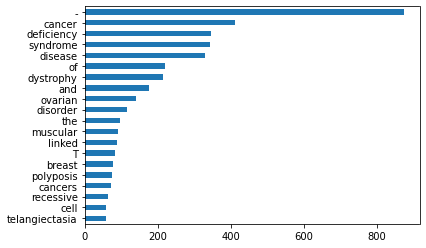

In [28]:
pd.value_counts(mark_2)[:20][::-1].plot(kind='barh')

In [29]:
# check '-'
l_=[]
for line in eda_df['tokens'].values:
    for idx, ww in enumerate(line):
        if ww == '-':
          strr= f'{line[idx-1]}{line[idx]}{line[idx+1]}'
          l_.append(strr)

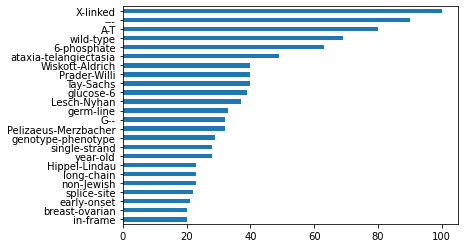

In [30]:
pd.value_counts(l_)[1:25][::-1].plot(kind='barh')

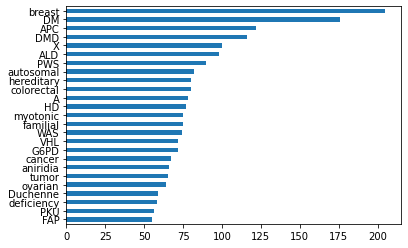

In [31]:
pd.value_counts(mark_1)[:25][::-1].plot(kind='barh')

In [32]:
eda_df['sentences'] = eda_df['tokens'].apply(lambda x: str(x)[1:-1])

In [33]:
import re
def clean_text(text):
    text=' '.join([i for i in text.split(',')])
    text=' '.join([i for i in text.split("'")])
    text=' '.join([i for i in text.split() if i.isalpha()])
    
    return text

In [34]:
eda_df['content'] = eda_df['sentences'].apply(clean_text)
eda_df

,id,ner_tags,tokens,sentences,content
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[Identification, of, APC2, ,, a, homologue, of...","'Identification', 'of', 'APC2', ',', 'a', 'hom...",Identification of a homologue of the adenomato...
1,1,"[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[The, adenomatous, polyposis, coli, (, APC, ),...","'The', 'adenomatous', 'polyposis', 'coli', '('...",The adenomatous polyposis coli APC tumour supp...
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[Complex, formation, induces, the, rapid, degr...","'Complex', 'formation', 'induces', 'the', 'rap...",Complex formation induces the rapid degradatio...
3,3,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, colon, carcinoma, cells, ,, loss, of, APC...","'In', 'colon', 'carcinoma', 'cells', ',', 'los...",In colon carcinoma cells loss of APC leads to ...
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Here, ,, we, report, the, identification, and...","'Here', ',', 'we', 'report', 'the', 'identific...",Here we report the identification and genomic ...
...,...,...,...,...,...
7293,936,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, an, attempt, to, resolve, this, issue, ,,...","'In', 'an', 'attempt', 'to', 'resolve', 'this'...",In an attempt to resolve this issue we have co...
7294,937,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[These, reagents, detect, a, 220, -, kD, prote...","'These', 'reagents', 'detect', 'a', '220', '-'...",These reagents detect a kD protein localized i...
7295,938,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Immunohistochemical, staining, of, human, bre...","'Immunohistochemical', 'staining', 'of', 'huma...",Immunohistochemical staining of human breast s...
7296,939,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Conversely, ,, BRCA1, expression, was, reduce...","'Conversely', ',', 'BRCA1', 'expression', 'was...",Conversely expression was reduced or undetecta...


In [35]:
df_train = pd.DataFrame(eda_df)

In [36]:
# metafeatures
df_train['word_count'] = df_train['content'].apply(lambda x: len(str(x).split()))
df_train['unique_word_count'] = df_train['content'].apply(lambda x: len(set(str(x).split())))
df_train['stop_word_count'] = df_train['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_train['mean_word_length'] = df_train['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_train['char_count'] = df_train['content'].apply(lambda x: len(str(x)))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [37]:
df_train.columns

Index(['id', 'ner_tags', 'tokens', 'sentences', 'content', 'word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count'], dtype='object')

In [38]:
df_stat = df_train.drop(['id', 'ner_tags', 'tokens', 'sentences','content'], axis=1)

In [39]:
df_stat.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count
count,7298.000000,7298.000000,7298.000000,7219.000000,7298.000000
mean,20.279666,18.186626,7.780214,5.507948,130.191285
std,10.013956,7.961982,4.502393,0.900552,63.979752
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,13.000000,5.000000,5.000000,87.000000
50%,19.000000,18.000000,7.000000,5.454545,124.000000
75%,26.000000,23.000000,10.000000,6.000000,167.000000
max,83.000000,57.000000,38.000000,13.000000,522.000000



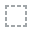
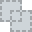
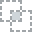
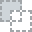
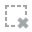
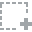
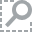
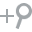
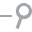
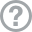
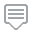
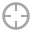
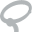
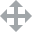
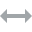
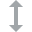
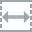
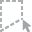
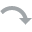
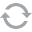
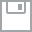
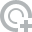
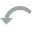
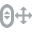
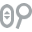
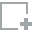
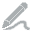
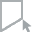
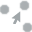
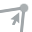
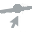

In [40]:
# plot
plot(df_stat)

DataPrep Report
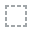
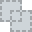
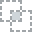
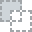
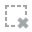
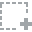
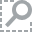
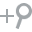
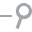
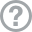
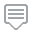
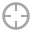
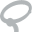
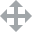
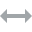
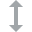
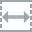
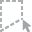
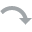
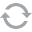
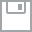
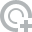
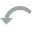
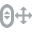
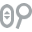
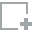
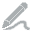
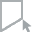
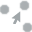
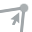
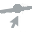

In [41]:
create_report(df_stat)

## Spacy NER

In [12]:
# prefered to use large model
%%capture
!python -m spacy download en_core_web_lg

In [13]:
import en_core_web_lg
nlp1 = en_core_web_lg.load()

In [14]:
# data preprocessing for spacy ner
data_for_spacy = []
for i in range(len(df_train)):
    stri = ' '
    ent = {}
    ent['entities'] = []
    for word in df_train.iloc[i]['tokens']:
        stri+=f'{word} '
    for idx, word in zip(df_train.iloc[i]['ner_tags'], df_train.iloc[i]['tokens']):
        if idx == 2:
            start_index = stri.find(word)
            end_index = start_index + len(word)
            s = (start_index, end_index, 'I_Disease')
            ent['entities'].append(s)
        if idx == 1:
            start_index = stri.find(word)
            end_index = start_index + len(word)
            s = (start_index, end_index, 'B_Disease')
            ent['entities'].append(s)
    ent['entities'] = list(set(ent['entities']))
    res = (stri, ent)
    data_for_spacy.append(res)
    if i == 10:
      break
pprint(data_for_spacy[:100])

[(' Identification of APC2 , a homologue of the adenomatous polyposis coli '
  'tumour suppressor . ',
  {'entities': [(72, 78, 'I_Disease'),
                (45, 56, 'B_Disease'),
                (67, 71, 'I_Disease'),
                (57, 66, 'I_Disease')]}),
 (' The adenomatous polyposis coli ( APC ) tumour - suppressor protein '
  'controls the Wnt signalling pathway by forming a complex with glycogen '
  'synthase kinase 3beta ( GSK - 3beta ) , axin / conductin and betacatenin . ',
  {'entities': [(40, 46, 'I_Disease'),
                (17, 26, 'I_Disease'),
                (38, 39, 'I_Disease'),
                (27, 31, 'I_Disease'),
                (34, 37, 'I_Disease'),
                (5, 16, 'B_Disease'),
                (32, 33, 'I_Disease')]}),
 (' Complex formation induces the rapid degradation of betacatenin . ',
  {'entities': []}),
 (' In colon carcinoma cells , loss of APC leads to the accumulation of '
  'betacatenin in the nucleus , where it binds to and activates th

In [15]:
model = None
output_dir=Path("/save_dir")
n_iter=100

In [16]:
# load model
if model is not None:
    nlp = spacy.load(model)  
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")

Created blank 'en' model


In [17]:
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe('ner')

## train spacy ner

In [20]:
for _, annotations in data_for_spacy:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(data_for_spacy)
        losses = {}
        for text, annotations in data_for_spacy:
            nlp.update(
                [text],  
                [annotations],  
                drop=0.5,  
                sgd=optimizer,
                losses=losses)
        print(losses)

{'ner': 3.819152453435232e-10}
{'ner': 5.296591592634817e-08}
{'ner': 4.780350489836701e-10}
{'ner': 9.728453735201762e-05}
{'ner': 6.519424561723752e-09}
{'ner': 3.666225821652616e-08}
{'ner': 6.388299580919725e-09}
{'ner': 0.00014930455396750818}
{'ner': 6.750447034914444e-08}
{'ner': 7.918688954362389e-10}
{'ner': 1.9642522339029542}
{'ner': 0.4867656545351817}
{'ner': 2.9661537318973344e-07}
{'ner': 0.00038402082994040075}
{'ner': 1.3762941091558814e-06}
{'ner': 0.0011265796798340436}
{'ner': 8.234994586081819e-08}
{'ner': 0.030028685927484082}
{'ner': 1.6429086899929132e-11}
{'ner': 2.0583639578793838e-14}
{'ner': 8.816482912079126e-11}
{'ner': 1.8519309294354709}
{'ner': 0.00016346167972429567}
{'ner': 3.7190610911806577e-07}
{'ner': 3.398647628158164e-14}
{'ner': 1.7638147790150174e-12}
{'ner': 7.448111251327303e-11}
{'ner': 2.568070288553971e-10}
{'ner': 1.54981940870386e-14}
{'ner': 0.00011045409471224142}
{'ner': 1.973758816719056}
{'ner': 1.602618152223385e-14}
{'ner': 6.825

In [21]:
# Testing the model
doc_1 = nlp(" In colon carcinoma cells , loss of APC leads to the accumulation of '
  'betacatenin in the nucleus , where it binds to and activates the Tcf - 4 '
  'transcription factor ( reviewed in [ 1 ] [ 2 ] ) . ")
doc_2 = nlp(" APC and APC2 may therefore have comparable functions in development and cancer . ")
print("Entities", [(ent.text, ent.label_) for ent in doc_1.ents])
print("Entities", [(ent.text, ent.label_) for ent in doc_2.ents])

Entities [('colon', 'B_Disease'), ('carcinoma', 'I_Disease')]
Entities [('cancer', 'B_Disease')]


## Preproc

In [42]:
eda_df = eda_df.drop(['id'],axis = 1)

In [43]:
eda_df['id'] = pd.Series(eda_df.index.values)

In [44]:
eda_df=eda_df.iloc[:7297]

In [47]:
%%capture
da = pd.DataFrame()
k = 0
for i in zip(eda_df['ner_tags'][:1], eda_df['tokens'][:1]):
  df = pd.DataFrame(np.vstack(i[0]), np.vstack(i[1]))
  df.columns=['tags']
  df['id'] = k
  k +=1
  df = df.reset_index()
  da = df
  break
  
for i in zip(eda_df['ner_tags'][1:], eda_df['tokens'][1:]):
  df = pd.DataFrame(np.vstack(i[0]), np.vstack(i[1]))
  df.columns=['tags']
  df['id'] = k
  k +=1
  df = df.reset_index()
  da = pd.concat([da,df], axis=0)

In [ ]:
da['index'] = da['index'].apply(lambda x: x[0])

In [ ]:
da.tail()

,index,tags,id
27,and,0,5431
28,increased,0,5431
29,survival,0,5431
30,.,0,5431
31,.,0,5431


In [ ]:
def change(x):
  if x == 0:
    return 'O'
  if x == 1:
    return 'B_Disease'
  if x == 2:
    return 'I_Disease'

In [ ]:
da['tags'] = da['tags'].apply(change)

In [ ]:
da.tags.unique()

array(['O', 'B_Disease', 'I_Disease'], dtype=object)

In [ ]:
da.rename(columns={"index":"words","tags":"labels","id":"sentence_id"}, inplace =True)

## BERT NER

In [ ]:
X = da[["sentence_id","words"]]
Y = da["labels"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.15)

In [ ]:
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [ ]:
train_data.labels = train_data['labels'].apply(lambda x: str(x))
test_data.labels = test_data['labels'].apply(lambda x: str(x))

In [ ]:
label = train_data["labels"].unique().tolist()
label

['O', 'I_Disease', 'B_Disease']

In [ ]:
args = NERArgs()
args.num_train_epochs = 2
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 64
args.eval_batch_size = 64

In [ ]:
model = NERModel('bert', 'bert-base-cased', labels=label, args=args)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.train_model(train_data, eval_data=test_data,acc=accuracy_score)

 Converting to features started.


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Training of bert model complete. Saved to outputs/.


(170, 0.16164357692879788)

In [ ]:
result, model_outputs, preds_list = model.eval_model(test_data)

In [ ]:
prediction, model_output = model.predict(['In colon carcinoma cells , loss of'])

 Converting to features started.


In [ ]:
print(prediction)
print_color(prediction)

[[{'In': 'O'}, {'colon': 'B_Disease'}, {'carcinoma': 'I_Disease'}, {'cells': 'O'}, {',': 'O'}, {'loss': 'O'}, {'of': 'O'}]]
In - O
colon - B_Disease
carcinoma - I_Disease
cells - O
, - O
loss - O
of - O
